In [ ]:
# Adopted from Erik - https://gitlab.au.dk/ausa/erik/e21010
# And modified to fit a newer iteration of the calibrations

# prerequisite: 
# run draw3aHists.ipynb, drawPadVetoedHists.ipynb and drawProtonHists.ipynb 
# and apply the printed calibrations in this file
## perhaps in the future it is better to write to a file and load it to make it easier to execute...

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak

In [3]:
raw = np.array([])
for batch in uproot.iterate(("../../data/unpacked/Si/098_*.root:h101",
                             "../../data/unpacked/Si/099_*.root:h101",
                             "../../data/unpacked/Si/100_*.root:h101",
                             "../../data/unpacked/Si/101_*.root:h101"), expressions=["U6F_E"], cut="U6FI == 8"):
    raw = np.append(raw, ak.flatten(batch.U6F_E))

In [4]:
base = "U6F8"
with uproot.open("../../data/cal/3aha_before.root") as file:
    # data
    y1a, x1a = file[base].to_numpy()
    x0a = np.min(x1a)
    x1a = x1a[:-1] + 0.5
    # tspectrum
    y2a, x2a = file[base + "A"].to_numpy()
    x2a = x2a[:-1] + 0.5 + x0a
    # peak positions, in found order
    x3a, y3a = file[base + "P"].values()
    x3a = x3a + x0a
with uproot.open("../../data/cal/pvha.root") as file:
    # data
    y1p, x1p = file[base].to_numpy()
    x0p = np.min(x1p)
    x1p = x1p[:-1] + 0.5
    # tspectrum
    y2p, x2p = file[base + "A"].to_numpy()
    x2p = x2p[:-1] + 0.5 + x0p
    # peak positions, in found order
    x3p, y3p = file[base + "P"].values()
    x3p = x3p + x0p

from scipy.optimize import curve_fit
def lin(x, a, b):
    return a*x + b
x3p[0:5]

array([122.99121592, 550.0001985 , 658.99761311, 617.99387851,
       275.99362755])

/tmp/ipykernel_658/1305841892.py:136: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if not ax.is_last_row():


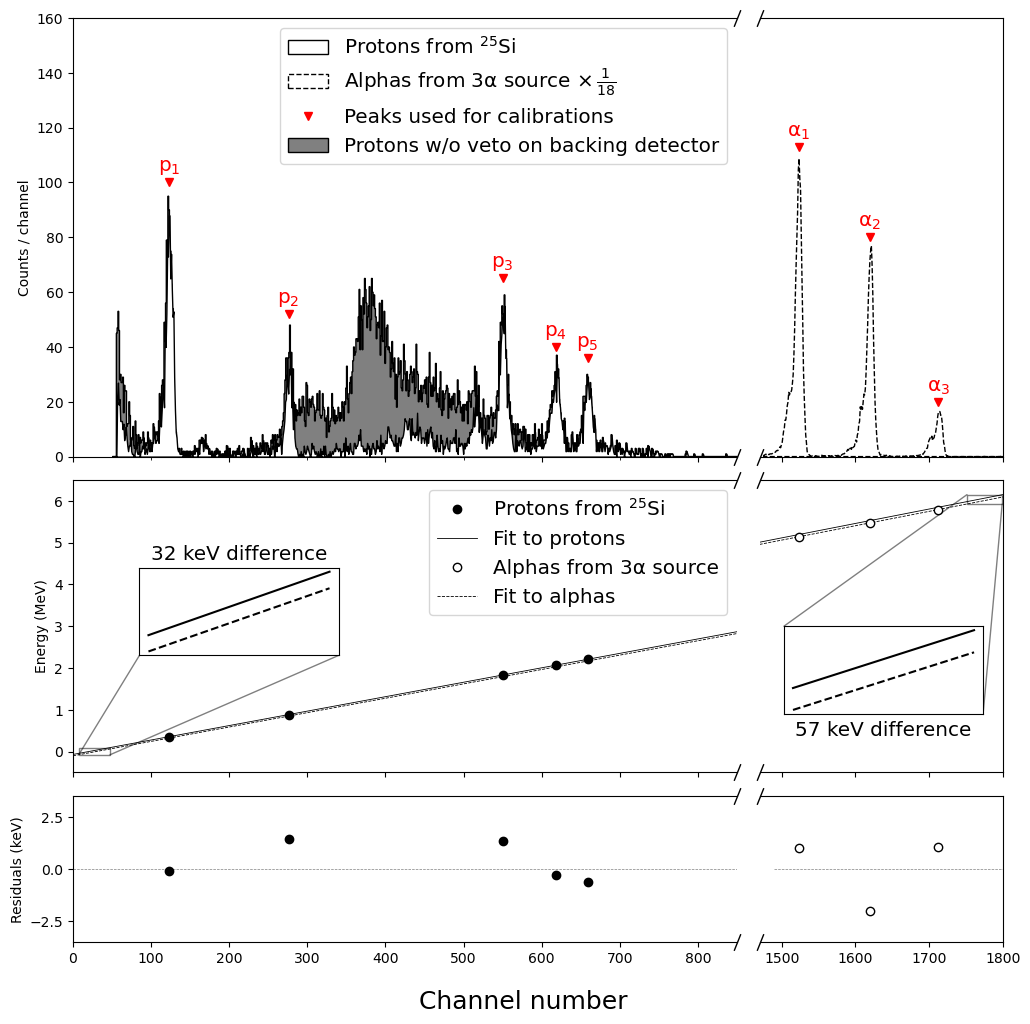

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

xl1 = 0
xu1 = 900
xl2 = 1470
xu2 = 1800

XP = np.linspace(xl1, xu1, 100)
XA = np.linspace(xl2, xu2, 100)
a_prot = 3.456223218586921
b_prot = -69.7727316735724
a_alph = 3.4421955727506153
b_alph = -101.90057879240454

def lin(x, a, b):
    return a*x + b
def lin_err(x, aerr, berr, aberr):
    return np.sqrt(aerr*x**2* + berr + x*aberr)


fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    sharey='row',
    figsize=(12, 12),
    gridspec_kw={
        'hspace': 0.08,
        'wspace': 0.05,
        'height_ratios': [3, 2, 1],
        'width_ratios': [xu1 - xl1, xu2 - xl2]
    }
)


ax = axes[0, 0]
ax.hist(raw, bins=np.arange(np.min(x1p), np.max(x1p), (np.max(x1p) - np.min(x1p))/len(x1p)),
        histtype='stepfilled', color='grey', edgecolor='k', label='Protons w/o veto on backing detector')
ax.fill_between(x1p, 0, y1p, edgecolor='k', facecolor='w', label='Protons from $^{25}\mathrm{Si}$')
ax.fill_between([-100, -99], 0, -100, edgecolor='k', facecolor='w', linestyle='--',
                label='Alphas from 3α source $\\times\,\\frac{1}{18}$')
ax.set_xticks(np.arange(0, 801, 200))
ax.set_xticks(np.arange(0, 801, 100), minor=True)
ax.set_ylim(0, 160)
ax.set_ylabel("Counts / channel")

y3p = [100, 52, 65, 40, 36]
ax.plot(np.sort(x3p[0:5]), y3p, c='r', ls='', marker='v', label='Peaks used for calibrations')
subs = ["1", "2", "3", "4", "5"]
for x, y, sub in zip(np.sort(x3p[0:5]), y3p, subs):
    ax.text(x, y+2, "$\mathrm{p_{%s}}$" % sub, va='bottom', ha='center', c='r', size='x-large')

handles, labels = ax.get_legend_handles_labels()
order = [1, 2, 3, 0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize='x-large')

ax = axes[1, 0]
ax.plot(x3p[0:5], lin(x3p[0:5], a_prot, b_prot)/1e3, 'ko', label='Protons from $^{25}\mathrm{Si}$')
ax.plot(XP, lin(XP, a_prot, b_prot)/1e3, 'k-', lw=0.6, label='Fit to protons')
ax.plot(-50, -50, 'ko', markerfacecolor='w', label='Alphas from 3α source')
ax.plot(XP, lin(XP, a_alph, b_alph)/1e3, 'k--', lw=0.6, label='Fit to alphas')
ax.set_ylim(-0.5, 6.5)
ax.set_ylabel("Energy (MeV)")
ax.legend(fontsize='x-large')

axin = ax.inset_axes([0.1, 0.4, 0.30, 0.30])
f1 = (0 < XP) & (XP < 50)
axin.plot(XP[f1], lin(XP[f1], a_prot, b_prot)/1e3, 'k-')
axin.plot(XP[f1], lin(XP[f1], a_alph, b_alph)/1e3, 'k--')
axin.set_xticks([])
axin.set_yticks([])
ax.indicate_inset_zoom(axin, edgecolor="black")
axin.set_title(f"{int(abs(b_alph-b_prot))} keV difference", fontsize='x-large')

ax = axes[2, 0]
ax.plot([xl1, xu1 - 20], [0, 0], ls='--', c='grey', lw=0.5)
ax.plot(np.sort(x3p[0:5]), [-0.10036446,  1.45314796,  1.3192754,  -0.29206019, -0.61011976], 'ko')
ax.set_ylim(-3.5, 3.5)
ax.set_ylabel("Residuals (keV)")


ax = axes[0, 1]
ax.fill_between(x1a[x1a > xl2 + 5], 0, y1a[x1a > xl2 + 5]/18, edgecolor='k', facecolor='w', linestyle='--')
ax.set_xticks(np.arange(1500, 1801, 100), minor=True)
ax.set_ylim(0, 160) 

y3a = [113, 80, 20]
ax.plot(x3a, y3a, c='r', ls='', marker='v')
subs = ["1", "2", "3"]
for x, y, sub in zip(x3a, y3a, subs):
    ax.text(x, y+2, "$\mathrm{\\alpha_{%s}}$" % sub, va='bottom', ha='center', c='r', size='x-large')

ax = axes[1, 1]
ax.plot(XA, lin(XA, a_prot, b_prot)/1e3, 'k-', lw=0.6)
ax.plot(XA, lin(XA, a_alph, b_alph)/1e3, 'k--', lw=0.6)
ax.plot(x3a[0:3], lin(x3a[0:3], a_alph, b_alph)/1e3, 'ko', markerfacecolor='w', zorder=10)
ax.set_ylim(-0.5, 6.5) 

axin = ax.inset_axes([0.1, 0.2, 0.30/((xu2 - xl2)/(xu1 - xl1)), 0.30])
f2 = (1750 < XA) & (XA < 1800)
axin.plot(XA[f2], lin(XA[f2], a_prot, b_prot)/1e3, 'k-')
axin.plot(XA[f2], lin(XA[f2], a_alph, b_alph)/1e3, 'k--')
axin.set_xticks([])
axin.set_yticks([])
ax.indicate_inset_zoom(axin, edgecolor="black")
axin.set_title(f"{int(abs(lin(xu2,a_prot,b_prot)-lin(xu2,a_alph,b_alph)))} keV difference", y=-0.34, fontsize='x-large')

ax = axes[2, 1]
ax.plot([20 + xl2, xu2], [0, 0], ls='--', c='grey', lw=0.5)
ax.plot(x3a[0:3], [ 0.98454137, -2.02258407,  1.03804269], 'ko', markerfacecolor='w')
ax.set_ylim(-3.5, 3.5) 


for ax in axes[:, 0]:
    ax.set_xlim(xl1, xu1-50)
for ax in axes[:, 1]:
    ax.set_xlim(xl2, xu2)

for ax in axes.flat:
    if not ax.is_last_row():
        ax.tick_params(labelbottom=False)

for ax in axes[:, 0]:
    ax.spines['right'].set_visible(False)
for ax in axes[:, 1]:
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)

d = 2.5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
for i in range(3):
    axes[i, 0].plot([1, 1], [0, 1], transform=axes[i, 0].transAxes, **kwargs)
    axes[i, 1].plot([0, 0], [0, 1], transform=axes[i, 1].transAxes, **kwargs)

fig.text(0.5, 0.06, 'Channel number', rotation='horizontal', ha='center', va='center', fontsize=18)

plt.rcParams.update({
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.labelsize': 18,
    'legend.fontsize': 14
})


plt.savefig("U6F8siacomp.pdf", bbox_inches='tight')
plt.show()

In [6]:
E0s = np.array([385.72, 904.02, 1843.2, 2076.7, 2217.4])
Es = np.loadtxt('U1-6EE.dat').flatten()

E0sa = np.array([5155.4, 5485.74, 5804.96])
Esa = np.array([])
Esa = np.append(Esa, np.loadtxt('U1U2a.dat').flatten())
Esa = np.append(Esa, np.loadtxt('U3U4a.dat').flatten())
Esa = np.append(Esa, np.loadtxt('U5a.dat').flatten())
Esa = np.append(Esa, np.loadtxt('U6a.dat').flatten())

In [15]:
from scipy.optimize import curve_fit
def gaus(x, mu, sigma, A):
    return A*np.exp(-0.5*(x-mu)**2/sigma**2)/sigma/np.sqrt(2*np.pi)

In [23]:
base = "U4F7"
with uproot.open("../../data/cal/3aha_before.root") as file:
    # data
    y1a_, x1a_ = file[base].to_numpy()
    x0a_ = np.min(x1a_)
    x1a_ = x1a_[:-1] + 0.5
    # tspectrum
    y2a_, x2a_ = file[base + "A"].to_numpy()
    x2a_ = x2a_[:-1] + 0.5 + x0a_
    # peak positions, in found order
    x3a_, y3a_ = file[base + "P"].values()
    x3a_ = x3a_ + x0a_
for i in range(len(x1a_)):
    xtmp = x1a_[i]
    if 1350 <= xtmp and xtmp <= 1380:
        y1a_[i] = 2 + np.random.uniform(-2, 2)
    if 1450 <= xtmp and xtmp <= 1475:
        y1a_[i] = 2 + np.random.uniform(-2, 2)
with uproot.open("../../data/cal/pha.root") as file:
    # data
    y1p_, x1p_ = file[base].to_numpy()
    x0p_ = np.min(x1p_)
    x1p_ = x1p_[:-1] + 0.5
    # tspectrum
    y2p_, x2p_ = file[base + "A"].to_numpy()
    x2p_ = x2p_[:-1] + 0.5 + x0p_
    # peak positions, in found order
    x3p_, y3p_ = file[base + "P"].values()
    x3p_ = x3p_ + x0p_

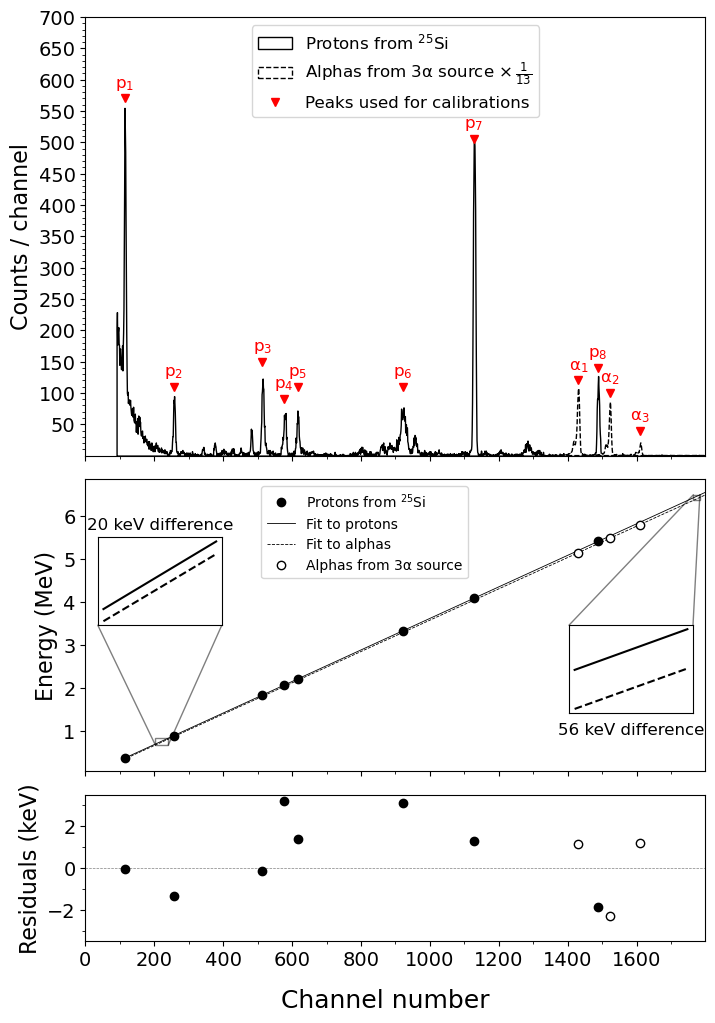

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


xl1_ = 120
xu1_ = 1800
xl2_ = 1350
xu2_ = 1650

def lin(x, a, b):
    return a*x + b
def lin_err(x, aerr, berr, aberr):
    return np.sqrt(aerr*x**2* + berr + x*aberr)
# U5F7 alpha 6.827784370976031 3.6347515137514383
# U5F7 alpha [ 1.13010269 -2.32512651  1.19502382]
#U5F7 p -19.90772265800977 3.6715577680429927
# [-1.17159999  1.30635843  4.25521774 -1.45560435  8.98940385  1.67941548 -1.88692107]
XP_ = np.linspace(xl1_, xu1_, 100)
aa_prot = 3.658247711535433
bb_prot = -40.70991056872542
aa_alph = 3.6343799742769543
bb_alph = -58.10160872802191


fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    sharex=True,
    figsize=(8, 12),  
    gridspec_kw={'hspace': 0.08, 'height_ratios': [3, 2, 1]}
)
plt.rcParams.update({
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.labelsize': 18,
    'legend.fontsize': 10
})
ax = axes[0]
xpl = np.min(x1p_)
xpu = np.max(x1p_)

ax.fill_between(x1p_, 0, y1p_, edgecolor='k', facecolor='w', label='Protons from $^{25}\mathrm{Si}$')
ax.fill_between(x1a_[x1a_ > xl2_ + 5], 0, y1a_[x1a_ > xl2_ + 5]/13, edgecolor='k', facecolor='w', linestyle='--',
                label='Alphas from 3α source $\\times\,\\frac{1}{13}$')

ax.set_yticks(np.arange(50, 750 + 50, 50))
ax.set_yticks(np.arange(10, 750 + 10, 10), minor=True)
ax.set_ylim(0, 700)
ax.set_ylabel("Counts / channel", fontsize=16)

x4p_ = np.array([113.99539713 , 256.99103479 , 514.00189975 , 577.00414222 , 616.00154576, 921.99575502 ,1127.99984529, 1487.99644195])
y4p_ = np.array([570,110,150,90,110,110,505,140])
ax.plot(x4p_, y4p_, c='r', ls='', marker='v', label='Peaks used for calibrations')
subs = ["1","2", "3", "4", "5", "6", "7", "8"]
for x, y, sub in zip(x4p_, y4p_, subs):
    ax.text(x, y+10, "$\mathrm{p_{%s}}$" % sub, va='bottom', ha='center', c='r', size='large')
y3a_ = [120,100,40]
ax.plot(x3a_[0:3], y3a_, c='r', ls='', marker='v')
subs = ["1", "2", "3"]
for x, y, sub in zip(x3a_[0:3], y3a_, subs):
    ax.text(x, y+10, "$\mathrm{\\alpha_{%s}}$" % sub, va='bottom', ha='center', c='r', size='large')

ax.legend(fontsize='large',loc='upper center')

ax = axes[1]
ax.plot(x4p_, lin(x4p_, aa_prot, bb_prot)/1e3, 'ko', label='Protons from $^{25}\mathrm{Si}$')
ax.plot(XP_, lin(XP_, aa_prot, bb_prot)/1e3, 'k-', lw=0.6, label='Fit to protons')
ax.plot(XP_, lin(XP_, aa_alph, bb_alph)/1e3, 'k--', lw=0.6, label='Fit to alphas')
ax.plot(x3a_[0:3], lin(x3a_[0:3], aa_alph, bb_alph)/1e3, 'ko', markerfacecolor='w', zorder=10,
        label='Alphas from 3α source')

axin1 = ax.inset_axes([0.02, 0.5, 0.20, 0.30])
f1_ = (200 < XP_) & (XP_ < 250)
axin1.plot(XP_[f1_], lin(XP_[f1_], aa_prot, bb_prot)/1e3, 'k-')
axin1.plot(XP_[f1_], lin(XP_[f1_], aa_alph, bb_alph)/1e3, 'k--')
axin1.set_xticks([])
axin1.set_yticks([])
ax.indicate_inset_zoom(axin1, edgecolor="black")
axin1.set_title(f"{int(abs(lin(xl1_,aa_prot,bb_prot)-lin(xl1_,aa_alph,bb_alph)))} keV difference")

axin2 = ax.inset_axes([0.98-0.20, 0.2, 0.20, 0.30])
f2_ = (1750 < XP_) & (XP_ < 1800)
axin2.plot(XP_[f2_], lin(XP_[f2_], aa_prot, bb_prot)/1e3, 'k-')
axin2.plot(XP_[f2_], lin(XP_[f2_], aa_alph, bb_alph)/1e3, 'k--')
axin2.set_xticks([])
axin2.set_yticks([])
ax.indicate_inset_zoom(axin2, edgecolor="black")
axin2.set_title(f"{int(abs(lin(xu2_,aa_prot,bb_prot)-lin(xu2_,aa_alph,bb_alph)))} keV difference", y=-0.34)

ax.set_yticks(np.arange(1, 6, 1), minor=True)
ax.legend( loc='upper center', bbox_to_anchor=(0.45, 1))
ax.set_ylabel("Energy (MeV)", fontsize=16)

ax = axes[2]
ax.plot([0, xu1_], [0, 0], ls='--', c='grey', lw=0.5)
ax.plot(x4p_, [-0.06449011, -1.35495435 ,-0.14636292 , 3.19582774 , 1.37366547  ,3.10104972 ,1.29705793 ,-1.86966797], 'ko')
ax.plot(x3a_[0:3], [1.12848728 ,-2.32176797 , 1.19328069], 'ko', markerfacecolor='w')
ax.set_ylabel("Residuals (keV)", fontsize=16)
ax.set_ylim(-3.5, 3.5)
ax.set_yticks(np.arange(-2, 2 + 2, 2), fontsize=14)
ax.set_yticks(np.arange(-3, 3 + 1, 1), minor=True)

ax.set_xlim(xl1_, xu1_)
ax.set_xticks(np.arange(0, 1800, 200), fontsize=14)
ax.set_xticks(np.arange(0, 1800, 100), minor=True)

fig.text(0.5, 0.06, 'Channel number', rotation='horizontal', ha='center', va='center', fontsize=18)

plt.savefig("U4F7siacomp.pdf", bbox_inches='tight')
plt.show()